<a href="https://colab.research.google.com/github/Proggleb/NLP-Spanish/blob/main/clasificacion_de_textos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de textos con 🤗 Transformers

> Cómo afinar un modelo de RoBERTa en español para clasificar las reseñas de Amazon.

## Configuración

Si está ejecutando este notebook en Google Colab, ejecute la siguiente celda para instalar las bibliotecas que necesitamos:

In [ ]:
!pip install transformers datasets

     |████████████████████████████████| 2.6 MB 4.2 MB/s 
     |████████████████████████████████| 264 kB 48.3 MB/s 
     |████████████████████████████████| 636 kB 28.0 MB/s 
     |████████████████████████████████| 3.3 MB 40.7 MB/s 
     |████████████████████████████████| 895 kB 40.6 MB/s 
     |████████████████████████████████| 243 kB 44.1 MB/s 
     |████████████████████████████████| 118 kB 48.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Para compartir tu modelo con la comunidad, primero crea una cuenta en el [Hugging Face Hub](https://huggingface.co/join). A continuación, ejecute la siguiente celda y proporcione su nombre de usuario y contraseña para generar un token de autenticación:

In [ ]:
# Esto sólo funciona en Google Colab! Para los notebooks normales, es necesario ejecutar esto en el terminal
!huggingface-cli login


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        
Username: lewtun
Password: 
Login successful
Your token: XKTnguXFlAZOlGGTcvhBZvsPoeSufIQjUWikWLAXDXcwOrMgOOLuFWwkamgEBTBXjHahlMAKQPyMfVCLonIxfgMKBwNBoabpohqjjYXyJCTzetIwMKEFdsHpwnzJafTX 

Your token has been saved to /root/.huggingface/token


Si no tienes instalado [Git LFS](https://git-lfs.github.com), puedes hacerlo descomentando y ejecutando la celda de abajo:

In [ ]:
!apt install git-lfs
!git config --global user.email "lewis.c.tunstall@gmail.com"
!git config --global user.name "Lewis Tunstall"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 1s (1,679 kB/s)
Selecting previously unselected package git-lfs.
(Reading database ... 148486 files and directories currently installed.)
Preparing to unpack .../git-lfs_2.3.4-1_amd64.deb ...
Unpacking git-lfs (2.3.4-1) ...
Setting up git-lfs (2.3.4-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


## Cargar y explorar los datos

Utilizaremos 🤗 Datasets para cargar y procesar nuestro conjunto de datos. Si no está familiarizado con 🤗 Datasets, vea el siguiente vídeo :)

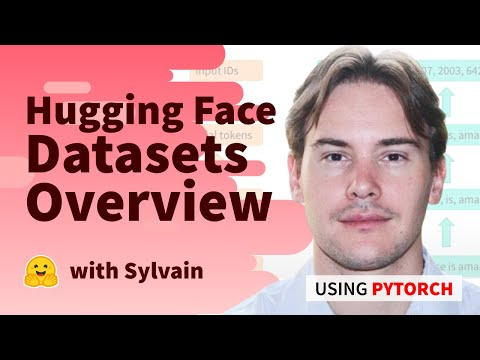

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo("_BZearw7f0w", width=600, height=400)

In [ ]:
from datasets import load_dataset

dataset = load_dataset("amazon_reviews_multi", "es")
dataset

Downloading:   0%|          | 0.00/2.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.62k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/77.5M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.93M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset amazon_reviews_multi downloaded and prepared to /root/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609. Subsequent calls will reuse this data.


DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
})

In [ ]:
import random
import pandas as pd
from datasets import ClassLabel
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    "Taken from https://github.com/huggingface/notebooks/blob/master/examples/text_classification.ipynb"
    
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

show_random_elements(dataset["train"])

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0042687,product_es_0544416,reviewer_es_0844941,1,"Nada que ver con la foto, no es gris es amarillo y azul, mala compra",No son los mismos colores,es,home
1,es_0825485,product_es_0769667,reviewer_es_0512480,5,"Gran producto, tamaño perfecto y muy comodo",Sencillo y practico,es,kitchen
2,es_0795846,product_es_0615269,reviewer_es_0802507,1,Es una malla de ocultacion en forma redonda. Imposible cubrir la piscina una persona y entre dos tampoco es que sea facil. No tiene ningun sentido... No vale para nada.,Inutil,es,lawn_and_garden
3,es_0256945,product_es_0557850,reviewer_es_0022832,1,"La he devuelto tras usarla 10 minutos porque me he desesperado al usarla. La superficie está tan satinada que el ratón se queda parado, he probado con dos ratones y el resultado es el mismo. Cuando se mueve, el movimiento no es uniforme y difícil de ajustar. Soy informático y el ratón está configurado en windows para que se mueva al máximo de rapidez, lo muevo en una superficie muy pequeña simplemente con un movimiento de los dedos sin desplazar la muñeca, y con esta alfombrilla es imposible. Coincido con otros comentarios, el gel es muy delgado y la alfombrilla no apoya bien por los bordes, lo cual afecta también al movimiento del ratón. La verdad es que me ha sorprendido porque siempre he utilizado esta marca a nivel personal y en el trabajo. No entiendo esta falta de calidad.",Devuelto a los 10 minutos de usarla,es,office_product
4,es_0872955,product_es_0419328,reviewer_es_0120718,4,"La relación calidad precio esta bien. Responde a lo esperado. Ademas, al ser luz led no se recalienta la pantalla, como en otras que he tenido.",Buen producto,es,home
5,es_0620877,product_es_0646862,reviewer_es_0717603,1,"Despues de un mes de haber hecho el pedido aun no la recibi , no se cual es la razon exacta xq cuando la pedi habia stock",Tamara G,es,apparel
6,es_0698733,product_es_0166940,reviewer_es_0623046,5,ES MUY BARATA Y ESTA BIEN PARA LLEVAR LA GUITARRA,BARATA,es,wireless
7,es_0553469,product_es_0711327,reviewer_es_0214311,4,En general todo bien.,Mantel y juego platos y servilletas correcto,es,toy
8,es_0410136,product_es_0857498,reviewer_es_0642773,5,Todo corrrcto en su plazo,Buen producto,es,automotive
9,es_0488572,product_es_0078026,reviewer_es_0169826,2,No está mal. Demasiado contenido para las páginas que tiene. No entra en detalle,Abarca demasiado para lo reducido del libro,es,book


In [ ]:
dataset.set_format("pandas")
df = dataset["train"][:]
df.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


In [ ]:
df["product_category"].value_counts()

home                        26962
wireless                    25886
toy                         13647
sports                      13189
pc                          11191
home_improvement            10879
electronics                 10385
beauty                       7337
automotive                   7143
kitchen                      6695
apparel                      5737
drugstore                    5513
book                         5264
furniture                    5229
baby_product                 4881
office_product               4771
lawn_and_garden              4237
other                        3937
pet_products                 3713
personal_care_appliances     3573
luggage                      3328
camera                       3029
shoes                        2754
digital_ebook_purchase       1843
video_games                  1733
jewelry                      1598
musical_instruments          1530
watch                        1490
industrial_supplies          1482
grocery       

In [ ]:
df["stars"].value_counts()

5    40000
4    40000
3    40000
2    40000
1    40000
Name: stars, dtype: int64

In [ ]:
dataset.reset_format()

## Fusionar las clasificaciones por estrellas

In [ ]:
dataset = dataset.filter(lambda x : x["stars"] != 3)

  0%|          | 0/160 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [ ]:
def merge_star_ratings(examples):
    if examples["stars"] <= 2:
        label = 0
    else:
        label = 1
    return {"labels": label}

In [ ]:
dataset = dataset.map(merge_star_ratings)

  0%|          | 0/160000 [00:00<?, ?ex/s]

  0%|          | 0/4000 [00:00<?, ?ex/s]

  0%|          | 0/4000 [00:00<?, ?ex/s]

In [ ]:
show_random_elements(dataset["train"], num_examples=3)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,labels
0,es_0532830,product_es_0339326,reviewer_es_0229106,1,Nunca llegó le Di una estrella pq no me dejaba publicar,Estafa,es,toy,0
1,es_0479770,product_es_0356345,reviewer_es_0437442,1,"No ajusta bien, el esparrago del asiento solo llega hasta la primera de los dos agujeros de las palancas, el resultado es que se tuercen un poco. Envié una consulta a la casa pero no contestaron que yo tenga constancia. Las instrucciones de montaje tampoco se entienden por la mala calidad de las imágenes, aunque la verdad es que se monta por lógica.",NO AJUSTA BIEN,es,sports,0
2,es_0045077,product_es_0571993,reviewer_es_0206751,5,"Parece magia, pero es una maravilla, para la gente que tiene la cara así bastante porosa como yo verás como se va todo en segundos. Limpia limpia y fuera todo los puntitos negros!!",Te limpia la cara en un santiamén,es,beauty,1


## Tokenizar las reseñas

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "BSC-TeMU/roberta-base-bne"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/613 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/509k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.46M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

## Tokenización de las reseñas

Para entender la siguiente sección, vea este breve vídeo sobre la tokenización:

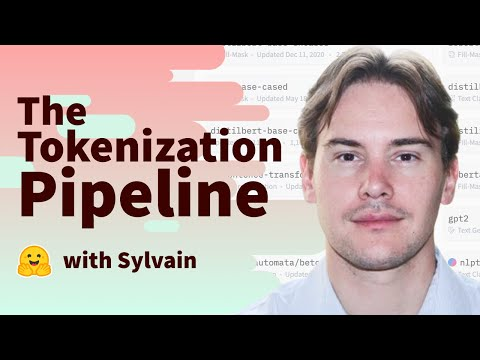

In [ ]:
YouTubeVideo("Yffk5aydLzg", width=600, height=400)

In [ ]:
tokenizer.vocab_size

50262

In [ ]:
text = "¡hola, me llamo lewis!"
tokenized_text = tokenizer.encode(text)

for token in tokenized_text:
    print(token, tokenizer.decode([token]))

0 <s>
1465 ¡
12616 hola
66 ,
503  me
17111  llamo
532  le
19514 wis
55 !
2 </s>


In [ ]:
encoded_text = tokenizer(text, return_tensors="pt")
encoded_text

{'input_ids': tensor([[    0,  1465, 12616,    66,   503, 17111,   532, 19514,    55,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
def tokenize_reviews(examples):
    return tokenizer(examples["review_body"], truncation=True)

In [ ]:
columns = dataset["train"].column_names
columns.remove("labels")
encoded_dataset = dataset.map(tokenize_reviews, batched=True, remove_columns=columns)
encoded_dataset

  0%|          | 0/160 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 160000
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 4000
    })
})

In [ ]:
encoded_dataset["train"][0]

{'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'input_ids': [0,
  10626,
  3383,
  361,
  503,
  847,
  36181,
  4747,
  334,
  1111,
  313,
  1369,
  1635,
  342,
  403,
  1594,
  4162,
  2957,
  369,
  10925,
  2],
 'labels': 0}

## Cargar el modelo preentrenado

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the model checkpoint at BSC-TeMU/roberta-base-bne were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at BSC-TeMU/roberta-base-bne and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj

### De las input IDs a los hidden states

In [ ]:
outputs = model(**encoded_text)
outputs

SequenceClassifierOutput([('logits',
                           tensor([[ 0.0043, -0.1177]], grad_fn=<AddmmBackward>))])

## Definir las métricas de rendimiento

In [ ]:
from datasets import load_metric 

metric = load_metric("accuracy")
metric

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Metric(name: "accuracy", features: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)}, usage: """
Args:
    predictions: Predicted labels, as returned by a model.
    references: Ground truth labels.
    normalize: If False, return the number of correctly classified samples.
        Otherwise, return the fraction of correctly classified samples.
    sample_weight: Sample weights.
Returns:
    accuracy: Accuracy score.
Examples:

    >>> accuracy_metric = datasets.load_metric("accuracy")
    >>> results = accuracy_metric.compute(references=[0, 1], predictions=[0, 1])
    >>> print(results)
    {'accuracy': 1.0}
""", stored examples: 0)

In [ ]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

## Afinar el modelo preentrenado

Si quiere entender más profundamente cómo funciona el Entrenador, vea el siguiente vídeo:

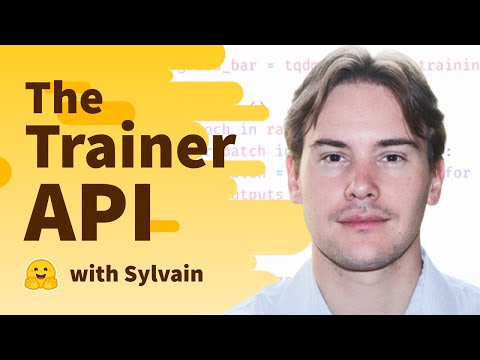

In [ ]:
YouTubeVideo("nvBXf7s7vTI", width=600, height=400)

In [ ]:
from transformers import TrainingArguments

model_name = model_checkpoint.split("/")[-1]

batch_size = 16
num_train_epochs=2
num_train_samples = 20_000
train_dataset = encoded_dataset["train"].shuffle(seed=42).select(range(num_train_samples))
logging_steps = len(train_dataset) // (2 * batch_size * num_train_epochs)

training_args = TrainingArguments(
    output_dir="results",
    num_train_epochs=num_train_epochs,     
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch", 
    logging_steps=logging_steps,
    push_to_hub=True,
    push_to_hub_model_id=f"{model_name}-finetuned-amazon_reviews_multi"
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model, 
    args=training_args, 
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer
)

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 20000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1250
/home/lewis/miniconda3/envs/hf/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.177600,0.176088,0.929500
2,0.092400,0.200465,0.930750


***** Running Evaluation *****
  Num examples = 4000
  Batch size = 32
Saving model checkpoint to results/checkpoint-625
Configuration saved in results/checkpoint-625/config.json
Model weights saved in results/checkpoint-625/pytorch_model.bin
tokenizer config file saved in results/checkpoint-625/tokenizer_config.json
Special tokens file saved in results/checkpoint-625/special_tokens_map.json
/home/lewis/miniconda3/envs/hf/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 32
Saving model checkpoint to results/checkpoint-1250
Configuration saved in results/checkpoint-1250/config.json
Model weights saved in results/checkpoint-1250/pytorch_model.bin
tokenizer config file saved in results/checkpoint-1250/tokenizer_c

TrainOutput(global_step=1250, training_loss=0.1513079273223877, metrics={'train_runtime': 223.1055, 'train_samples_per_second': 179.287, 'train_steps_per_second': 5.603, 'total_flos': 2744100307436160.0, 'train_loss': 0.1513079273223877, 'epoch': 2.0})

## Empuje hacia el Hugging Face Hub

Para más detalles sobre el envío de modelos al Hub, vea el siguiente vídeo:

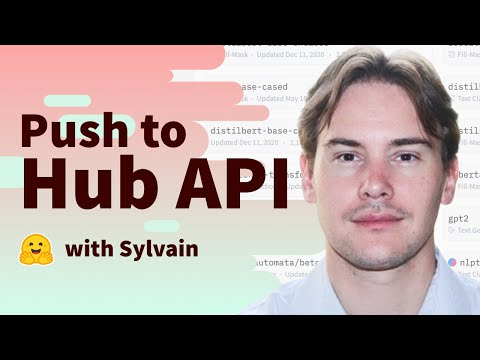

In [ ]:
YouTubeVideo("A5IWIxsHLUw", width=600, height=400)

In [ ]:
trainer.push_to_hub()

Saving model checkpoint to results
Configuration saved in results/config.json
Model weights saved in results/pytorch_model.bin
tokenizer config file saved in results/tokenizer_config.json
Special tokens file saved in results/special_tokens_map.json


'https://huggingface.co/lewtun/roberta-base-bne-finetuned-amazon_reviews_multi/commit/0e74f9c0068eb69400f45fab3e89242b3ecd85f0'

## Descargue el modelo desde el Hub

In [ ]:
from transformers import pipeline

model_checkpoint = "lewtun/roberta-base-bne-finetuned-amazon_reviews_multi"
pipe = pipeline("sentiment-analysis", model=model_checkpoint)

https://huggingface.co/lewtun/roberta-base-bne-finetuned-amazon_reviews_multi/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmph6qq2zxy


Downloading:   0%|          | 0.00/752 [00:00<?, ?B/s]

storing https://huggingface.co/lewtun/roberta-base-bne-finetuned-amazon_reviews_multi/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/8bfe8034b9f3457b4aa584e9a8069b1cbb414feb60b0a682e58db822d2a47303.0f71f2eaa9f414cf1b74168eaa6101eaf1d6f2f761afb865947e934b4b74990d
creating metadata file for /root/.cache/huggingface/transformers/8bfe8034b9f3457b4aa584e9a8069b1cbb414feb60b0a682e58db822d2a47303.0f71f2eaa9f414cf1b74168eaa6101eaf1d6f2f761afb865947e934b4b74990d
loading configuration file https://huggingface.co/lewtun/roberta-base-bne-finetuned-amazon_reviews_multi/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/8bfe8034b9f3457b4aa584e9a8069b1cbb414feb60b0a682e58db822d2a47303.0f71f2eaa9f414cf1b74168eaa6101eaf1d6f2f761afb865947e934b4b74990d
Model config RobertaConfig {
  "_name_or_path": "BSC-TeMU/roberta-base-bne",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "bos_token_id": 0,


Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

storing https://huggingface.co/lewtun/roberta-base-bne-finetuned-amazon_reviews_multi/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/fcf97e955b2af57170b2915ad329c468af92f5801b6f12e325b4676d071cf7fa.3a3fc6ec80392faf32d3dd5aab18a783c23167b25b2639f1921ba1950d85ebbe
creating metadata file for /root/.cache/huggingface/transformers/fcf97e955b2af57170b2915ad329c468af92f5801b6f12e325b4676d071cf7fa.3a3fc6ec80392faf32d3dd5aab18a783c23167b25b2639f1921ba1950d85ebbe
loading weights file https://huggingface.co/lewtun/roberta-base-bne-finetuned-amazon_reviews_multi/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/fcf97e955b2af57170b2915ad329c468af92f5801b6f12e325b4676d071cf7fa.3a3fc6ec80392faf32d3dd5aab18a783c23167b25b2639f1921ba1950d85ebbe
All model checkpoint weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the model checkpoint at lewtun

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

storing https://huggingface.co/lewtun/roberta-base-bne-finetuned-amazon_reviews_multi/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/c8cb37eba441bb3b3290b15946240fc2c7ec8a00e6ca59a16076255e7b005d99.735b884da1059c92a75233ccce6eca23ed0041c535da54b84aa82968aeaf26cd
creating metadata file for /root/.cache/huggingface/transformers/c8cb37eba441bb3b3290b15946240fc2c7ec8a00e6ca59a16076255e7b005d99.735b884da1059c92a75233ccce6eca23ed0041c535da54b84aa82968aeaf26cd
https://huggingface.co/lewtun/roberta-base-bne-finetuned-amazon_reviews_multi/resolve/main/vocab.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpj_59fpii


Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

storing https://huggingface.co/lewtun/roberta-base-bne-finetuned-amazon_reviews_multi/resolve/main/vocab.json in cache at /root/.cache/huggingface/transformers/08e76e987556a95db77809ecf11eb025c3907cfb74c954d0e1fe7e77f8247e71.0b968504b15b2f5e6e9e491723f31987782cb976064aff9a7c6188cc2d5ce8bc
creating metadata file for /root/.cache/huggingface/transformers/08e76e987556a95db77809ecf11eb025c3907cfb74c954d0e1fe7e77f8247e71.0b968504b15b2f5e6e9e491723f31987782cb976064aff9a7c6188cc2d5ce8bc
https://huggingface.co/lewtun/roberta-base-bne-finetuned-amazon_reviews_multi/resolve/main/merges.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmprmn7ytuz


Downloading:   0%|          | 0.00/509k [00:00<?, ?B/s]

storing https://huggingface.co/lewtun/roberta-base-bne-finetuned-amazon_reviews_multi/resolve/main/merges.txt in cache at /root/.cache/huggingface/transformers/825f55eb1e003dce73b3c694f8b414ffa677e14029209282a7afa0adf07aee4c.0d24ae8bd5fabb1f5020f91bc602cefeb5a2938ab77e21769d28776345634b23
creating metadata file for /root/.cache/huggingface/transformers/825f55eb1e003dce73b3c694f8b414ffa677e14029209282a7afa0adf07aee4c.0d24ae8bd5fabb1f5020f91bc602cefeb5a2938ab77e21769d28776345634b23
https://huggingface.co/lewtun/roberta-base-bne-finetuned-amazon_reviews_multi/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp4yzd986k


Downloading:   0%|          | 0.00/1.46M [00:00<?, ?B/s]

storing https://huggingface.co/lewtun/roberta-base-bne-finetuned-amazon_reviews_multi/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/a7c9752a71f608c0650307102524c80b583dccd174849d094b96e81cd1765626.c32009059de03bfd14ed3d1718b64ea822148f9cabd7100826a0d17d4e47596c
creating metadata file for /root/.cache/huggingface/transformers/a7c9752a71f608c0650307102524c80b583dccd174849d094b96e81cd1765626.c32009059de03bfd14ed3d1718b64ea822148f9cabd7100826a0d17d4e47596c
https://huggingface.co/lewtun/roberta-base-bne-finetuned-amazon_reviews_multi/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmprmahst2m


Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

storing https://huggingface.co/lewtun/roberta-base-bne-finetuned-amazon_reviews_multi/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/fa6a00346784f597094dc041826a1e06a88771574368f7f902b135ab8219078f.cb2244924ab24d706b02fd7fcedaea4531566537687a539ebb94db511fd122a0
creating metadata file for /root/.cache/huggingface/transformers/fa6a00346784f597094dc041826a1e06a88771574368f7f902b135ab8219078f.cb2244924ab24d706b02fd7fcedaea4531566537687a539ebb94db511fd122a0
loading file https://huggingface.co/lewtun/roberta-base-bne-finetuned-amazon_reviews_multi/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/08e76e987556a95db77809ecf11eb025c3907cfb74c954d0e1fe7e77f8247e71.0b968504b15b2f5e6e9e491723f31987782cb976064aff9a7c6188cc2d5ce8bc
loading file https://huggingface.co/lewtun/roberta-base-bne-finetuned-amazon_reviews_multi/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/825f55eb1e003dce73b3c694f8b414ffa677e1

In [ ]:
pipe("¡me encanta el ipad!")

[{'label': 'LABEL_1', 'score': 0.9947712421417236}]